In [ ]:
!pip install 'fsspec>=0.3.3'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 7.5 MB/s 


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import keras
import random
import re
import dask.bag as db
import json
import pandas as pd
import re
import nltk
nltk.download('stopwords')
import jieba as jb

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. Upload json file

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json
token = {"username":"karinmao","key":"0145306b9df944a40f90e51f15167f9c"}
with open('/content/kaggle.json','w') as file:
  json.dump(token,file)

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content
!kaggle datasets download -d Cornell-University/arxiv
!unzip -uq "/content/datasets/Cornell-University/arxiv/arxiv.zip" -d "/content/datasets/Cornell-University/arxiv"

- path is now set to: /content
 99% 1.04G/1.05G [00:07<00:00, 170MB/s]
100% 1.05G/1.05G [00:07<00:00, 154MB/s]


In [ ]:
# load data
docs = db.read_text('/content/datasets/Cornell-University/arxiv/arxiv-metadata-oai-snapshot.json').map(json.loads)

# 2. Exploratory data analysis

Do the exploratory analysis for the samples from year 2021.

In [ ]:
# Submissions by datetime
get_year = lambda x: x['versions'][-1]['created'].split(' ')[3]

# get only necessary fields
trim = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],
                  'time':x['versions'][-1]['created'].split(' ')[3]}

# filter for papers published on or after ????-01-01
docs_df = (docs.filter(lambda x: int(get_year(x)) > 2020)
               .filter(lambda x: int(get_year(x)) < 2022)
               .map(trim)
               .compute())

# convert to pandas dataframe
docs_df = pd.DataFrame(docs_df)

# add main category: list
docs_df['main_category'] = docs_df.category.apply(lambda x:[a.split('.')[0] for a in x][0].split())

# add main category 2: not list
docs_df['main_category2'] = docs_df.main_category.apply(lambda x: x[0])

In [ ]:
docs_df

,id,title,category,abstract,time,main_category,main_category2
0,0704.0479,The affine part of the Picard scheme,"[math.AG, math.KT]",We describe the maximal torus and maximal un...,2021,[math],math
1,0705.4060,C*- Algebras and Thermodynamic Formalism,"[math.DS, math.OA]",We present a detailed exposition (for a Dyna...,2021,[math],math
2,0706.2239,Infinitesimal Castelnuovo Theory in Abelian Va...,[math.AG],The purpose of this article is to show that ...,2021,[math],math
3,0707.4296,Infrared renormalization of two-loop integrals...,[hep-ph],We describe details of the renormalization o...,2021,[hep-ph],hep-ph
4,0707.4657,The Informational Conception and Basic Physics,[physics.gen-ph],"In our previous arXiv papers (""The Informati...",2021,[physics],physics
...,...,...,...,...,...,...,...
203291,physics/0701101,Submitting Jobs on Grid,[physics.comp-ph],This is an user's introduction to grid using...,2021,[physics],physics
203292,physics/0701308,Boltzmann's Concept of Reality,"[physics.hist-ph, gr-qc, physics.pop-ph, physi...",In this article we describe and analyze the ...,2021,[physics],physics
203293,physics/9903027,Matter and Space with Torsion,"[physics.gen-ph, physics.class-ph]",General equations of the unified field theor...,2021,[physics],physics
203294,quant-ph/0010065,Artificial Orbitals and a Solution to Grover's...,[quant-ph],By allowing measurements of observables othe...,2021,[quant-ph],quant-ph


In [ ]:
docs_df2 = docs_df[['title','main_category2','abstract','time','category']]
docs_df2

,title,main_category2,abstract,time,category
0,The affine part of the Picard scheme,math,We describe the maximal torus and maximal un...,2021,"[math.AG, math.KT]"
1,C*- Algebras and Thermodynamic Formalism,math,We present a detailed exposition (for a Dyna...,2021,"[math.DS, math.OA]"
2,Infinitesimal Castelnuovo Theory in Abelian Va...,math,The purpose of this article is to show that ...,2021,[math.AG]
3,Infrared renormalization of two-loop integrals...,hep-ph,We describe details of the renormalization o...,2021,[hep-ph]
4,The Informational Conception and Basic Physics,physics,"In our previous arXiv papers (""The Informati...",2021,[physics.gen-ph]
...,...,...,...,...,...
203291,Submitting Jobs on Grid,physics,This is an user's introduction to grid using...,2021,[physics.comp-ph]
203292,Boltzmann's Concept of Reality,physics,In this article we describe and analyze the ...,2021,"[physics.hist-ph, gr-qc, physics.pop-ph, physi..."
203293,Matter and Space with Torsion,physics,General equations of the unified field theor...,2021,"[physics.gen-ph, physics.class-ph]"
203294,Artificial Orbitals and a Solution to Grover's...,quant-ph,By allowing measurements of observables othe...,2021,[quant-ph]


In [ ]:
# define stopwords
stopwords = nltk.corpus.stopwords.words("english")

# remove punctuation
docs_df2['clean_review'] = docs_df2['abstract'].apply(remove_punctuation)

# remove stopwords
docs_df2['cut'] = docs_df2['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
docs_df2 = docs_df2[['title','cut','main_category2','category','time']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.871 seconds.
Prefix dict has been built successfully.


In [ ]:
docs_df2

,title,cut,main_category2,category,time
0,The affine part of the Picard scheme,We describe maximal torus maximal ...,math,"[math.AG, math.KT]",2021
1,C*- Algebras and Thermodynamic Formalism,We present detailed exposition D...,math,"[math.DS, math.OA]",2021
2,Infinitesimal Castelnuovo Theory in Abelian Va...,The purpose article show C...,math,[math.AG],2021
3,Infrared renormalization of two-loop integrals...,We describe details renormalization ...,hep-ph,[hep-ph],2021
4,The Informational Conception and Basic Physics,In previous arXiv papers The Infor...,physics,[physics.gen-ph],2021
...,...,...,...,...,...
203291,Submitting Jobs on Grid,This users introduction grid usi...,physics,[physics.comp-ph],2021
203292,Boltzmann's Concept of Reality,In article describe analyze co...,physics,"[physics.hist-ph, gr-qc, physics.pop-ph, physi...",2021
203293,Matter and Space with Torsion,General equations unified field th...,physics,"[physics.gen-ph, physics.class-ph]",2021
203294,Artificial Orbitals and a Solution to Grover's...,By allowing measurements observables ...,quant-ph,[quant-ph],2021


In [ ]:

docs_df2.to_csv("data20172021.csv")

In [ ]:
# distribution for categories
d = {'category':docs_df['main_category2'].value_counts().index, 'count': docs_df['main_category2'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
df_cat

,category,count
0,cs,65775
1,math,43172
2,cond-mat,17366
3,astro-ph,15292
4,physics,14687
5,eess,8760
6,quant-ph,8075
7,stat,6027
8,hep-ph,5490
9,hep-th,4292


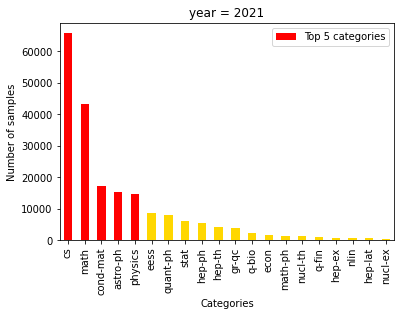

In [ ]:
# plot samples - categories
df_cat.plot('category','count',label='Top 5 categories',kind='bar',color=['r','r','r','r','r','gold','gold','gold','gold','gold','gold','gold','gold','gold','gold','gold','gold','gold','gold','gold'])
plt.xlabel('Categories')
plt.ylabel('Number of samples')
plt.title('year = 2021')
plt.legend()

# # plot samples - categories (log scale)
# df_cat.plot('category','count',label='Top 5 categories',kind='bar',logy=True,color=['r','r','r','r','r','r','r','r','gold','gold','gold','gold','gold','gold','gold','gold','gold','gold','gold','gold'])
# plt.xlabel('Categories')
# plt.ylabel('log scale: Number of samples')

# 3. Functions

In [ ]:
# Define the cross validation split function to get 5 folds
def cross_val_split(data, num_folds):
    
    # data: data set
    # num_folds: number folds of the cross validation
    # returns: folds: a list of folds
  
    fold_size = int(len(data) / num_folds)
    data_perm = np.random.permutation(data)
    folds = []
    
    for k in range(num_folds):
        folds.append(data_perm[k*fold_size:(k+1)*fold_size, :])

    return folds

In [ ]:
def remove_punctuation(line):
    line = str(line)
    if line.strip() == '':
        return ''
    rule = re.compile("[^0-9a-zA-Z\s-]")
    line = rule.sub('', line).strip()
    return line


def LSTM_main(X, Y, num_words, epochs, batch_size, EMBEDDING_DIM=100):

    #MAX_NB_WORDS = 5000
    # Split training set and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
    #_train, X_test, Y_train, Y_test =X[train], X[test], Y[train], Y[test] 

    # Define model
    model = Sequential()
    model.add(Embedding(input_dim = num_words, output_dim = EMBEDDING_DIM, input_length = X.shape[1])) # EMBEDDING_DIM: the dimension of the Embedding layer
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit the model
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    # evaluate the model
    scores = model.evaluate(X_test, Y_test)
    
    # save model to single file
    #model.save('lstm_fold5.h5')

    return history, scores




def LSTM_2_classification(year, epochs = 2, batch_size = 64):

    MAX_SEQUENCE_LENGTH = 250

    # use dask.bag to load json file
    docs = db.read_text('/content/datasets/Cornell-University/arxiv/arxiv-metadata-oai-snapshot.json').map(json.loads)

    # Submissions by datetime
    get_year = lambda x: x['versions'][-1]['created'].split(' ')[3]

    # get only necessary fields
    trim = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],
                      'time':x['versions'][-1]['created'].split(' ')[3]}

    # filter for papers published on or after ????-01-01
    docs_df = (docs.filter(lambda x: int(get_year(x)) > year-1)
                   .filter(lambda x: int(get_year(x)) < year+1)
                   .map(trim)
                   .compute())

    # convert to pandas dataframe
    docs_df = pd.DataFrame(docs_df)

    # add main category
    docs_df['main_category'] = docs_df.category.apply(lambda x:[a.split('.')[0] for a in x][0].split())
    
    # add main category 2 
    docs_df['main_category2'] = docs_df.main_category.apply(lambda x: x[0])

    # discard categories with number of samples < 500
    d = {'cat':docs_df['main_category2'].value_counts().index, 'count': docs_df['main_category2'].value_counts()}
    df_cat = pd.DataFrame(data=d).reset_index(drop=True)
    df_cat.drop(df_cat[df_cat['count']<500].index)
    discard_cat = df_cat[df_cat['count']<500].cat.tolist()
    docs_df = docs_df.drop(docs_df[(docs_df.main_category2.apply(lambda x: x in discard_cat)==True)].index)

    # find all categories
    cat_list = docs_df['main_category2'].unique()

    list_2 = [('cs', 'math'),
          ('cs', 'cond-mat'),
          ('cs', 'astro-ph'),
          ('cs', 'physics'),
          ('math', 'cond-mat'),
          ('math', 'astro-ph'),
          ('math', 'physics'),
          ('cond-mat', 'astro-ph'),
          ('cond-mat', 'physics'),
          ('astro-ph', 'physics')]

    # initialize accuracy, var
    acc = np.zeros(len(list_2))
    num = np.zeros(len(list_2))

    for i in range(len(list_2)):

        print(list_2[i])

        # define two categories
        cat1 = list_2[i][0]
        cat2 = list_2[i][1]

        # filter for papers in 'cat1' or 'cat2' area
        docs_df2 = docs_df[(docs_df.main_category.apply(lambda x: cat1 in x )==True)|(docs_df.main_category.apply(lambda x: cat2 in x )==True)]

        # define stopwords
        stopwords = nltk.corpus.stopwords.words("english")

        # remove punctuation
        docs_df2['clean_review'] = docs_df2['abstract'].apply(remove_punctuation)

        # remove stopwords
        docs_df2['cut'] = docs_df2['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
        docs_df3 = docs_df2[['cut','main_category2']]

        # get the number of papers
        num[i] = len(docs_df3)

        # cat tansfer to id
        docs_df3['cat_id'] = docs_df3['main_category2'].factorize()[0]
        cat_id_df = docs_df3[['main_category2', 'cat_id']].drop_duplicates().sort_values('cat_id').reset_index(drop=True)
        cat_to_id = dict(cat_id_df.values)
        id_to_cat = dict(cat_id_df[['cat_id', 'main_category2']].values)

        # Create the tokenizer object and train on abstract
        #tokenizer = Tokenizer(num_words = MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True) # MAX_NB_WORDS: the number of most frequently used words
        tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
        tokenizer.fit_on_texts(docs_df3['cut'].values)
        word_index = tokenizer.word_index
        num_words = len(word_index) + 1

        # Convert text to sequences of integers
        X = tokenizer.texts_to_sequences(docs_df3['cut'].values)

        # fill X
        X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) # MAX_SEQUENCE_LENGTH: the maximum length of each cut review

        # get onehot
        Y = pd.get_dummies(docs_df3['cat_id']).values

        # # define n-fold cross validation test harness
        # kfold = StratifiedKFold(n_splits = n_folds, shuffle=True, random_state=7)
        # cvscores = []
        # cvhistory = []

        # for train, test in kfold.split(X, Y.argmax(1)):

        #     history, scores = LSTM_main(X, Y, train, test, num_words, epochs, batch_size, EMBEDDING_DIM=100)
        #     cvscores.append(scores[1])
        #     cvhistory.append(history.history)

        history, scores = LSTM_main(X, Y, num_words, epochs, batch_size, EMBEDDING_DIM=100)
        acc[i] = scores[1]
        print('acc',scores[1])

        # Compute test accuracy
        #acc[i] = history.history['val_accuracy'][epochs-1]
    
    return acc,num




In [ ]:
results_acc, results_num = LSTM_2_classification(2021, epochs = 2, batch_size = 64)

('cs', 'cond-mat')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.805 seconds.
Prefix dict has been built successfully.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set 

Epoch 1/2
1166/1166 [==============================] - 1099s 938ms/step - loss: 0.0688 - accuracy: 0.9789
Epoch 2/2
260/260 [==============================] - 16s 59ms/step - loss: 0.0388 - accuracy: 0.9906
acc 0.9905899167060852
('cs', 'astro-ph')
Epoch 1/2
1137/1137 [==============================] - 1046s 918ms/step - loss: 0.0639 - accuracy: 0.9810
Epoch 2/2
253/253 [==============================] - 15s 60ms/step - loss: 0.0251 - accuracy: 0.9941
acc 0.9940630793571472
('cs', 'physics')
Epoch 1/2
1129/1129 [==============================] - 1041s 920ms/step - loss: 0.1300 - accuracy: 0.9555
Epoch 2/2
251/251 [==============================] - 15s 59ms/step - loss: 0.0779 - accuracy: 0.9732
acc 0.9732053875923157
('math', 'cond-mat')
Epoch 1/2
848/848 [==============================] - 820s 965ms/step - loss: 0.0910 - accuracy: 0.9687
Epoch 2/2
189/189 [==============================] - 12s 60ms/step - loss: 0.0772 - accuracy: 0.9841
acc 0.9840742945671082
('math', 'astro-ph')
Epoc

In [ ]:
y1 = results_num.mean(axis=0)
y2 = results_acc.std(axis=0)
y3 = results_acc.var(axis=0)
y4 = results_acc.mean(axis=0)

In [ ]:
dfy1 = pd.DataFrame(y1)
dfy2 = pd.DataFrame(y2)
dfy3 = pd.DataFrame(y3)
dfy4 = pd.DataFrame(y4)
y1y2 = pd.concat([dfy1, dfy2, dfy3, dfy4], axis=1)
y1y2.columns = ['num', 'std', 'var', 'mean']
y1y2.sort_values('num', inplace=True)
y1y2

In [ ]:
y1y2.plot(x = 'num', y = 'var', kind = 'line')
plt.xlabel('number of samples')
plt.ylabel('variance')

In [ ]:
y1y2.plot(x = 'num', y = 'std', kind = 'line')
plt.xlabel('number of samples')
plt.ylabel('standard deviation')

In [ ]:
y1y2.plot(x = 'num', y = 'mean', kind = 'line')
plt.xlabel('number of samples')
plt.ylabel('mean')

In [ ]:
print('his_total',his_total)
print('results_acc',results_acc)
print('results_num',results_num)
print('list_2',list_2)

his_total {'start': 2017, 'end': 2017, 'n_folds': 4, 'n_topics': 2, 'num_cal': 10, 'epochs': 2, 'batch_size': 64, 'list_year': array([2017]), 'n': 1, 'names': {...}, 'docs_df0':                       id  ... main_category2
0              0704.0558  ...           math
1              0704.1633  ...           math
2              0705.2377  ...           math
3              0705.4545  ...           math
4              0706.0548  ...           math
...                  ...  ...            ...
120036  quant-ph/0403160  ...       quant-ph
120037  quant-ph/0503201  ...       quant-ph
120038  quant-ph/0512178  ...       quant-ph
120039  quant-ph/0609043  ...       quant-ph
120040  quant-ph/0612199  ...       quant-ph

[119253 rows x 7 columns], 'year0': [[{'loss': [0.1434648185968399, 0.05410360172390938], 'accuracy': [0.9695035219192505, 0.9824467897415161]}, {'loss': [0.1428176462650299, 0.05843523517251015], 'accuracy': [0.9699481129646301, 0.9809848666191101]}, {'loss': [0.14394605159759521

In [ ]:
# 5 fold - 2017
acc5 = [0.98314545,0.98923401,0.99204117,0.91771265,0.92758449,0.95833596,0.98456494,0.93495493,0.97361616,0.98652915]
acc4 = [0.97988749,0.99093966,0.99252126,0.91192651,0.92583172,0.95690276,0.98544694,0.80807967,0.9726298,0.86065996]
acc3 = [0.98095143,0.98875435,0.98504351,0.91578255,0.92651902,0.95494827,0.98544689,0.82118056,0.97051309,0.96361425]
acc2 = [0.97579855,0.98502386,0.99217838,0.87550202,0.9254193,0.95429671,0.97839126,0.74122238,0.93947518,0.96867532]

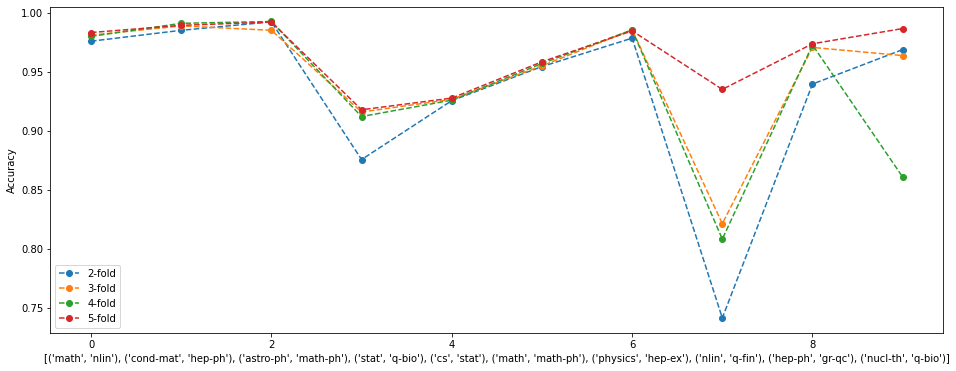

In [ ]:
list_2 = [('math', 'nlin'), 
          ('cond-mat', 'hep-ph'),
          ('astro-ph', 'math-ph'),
          ('stat', 'q-bio'),
          ('cs', 'stat'),
          ('math', 'math-ph'),
          ('physics', 'hep-ex'),
          ('nlin', 'q-fin'),
          ('hep-ph', 'gr-qc'),
          ('nucl-th', 'q-bio')]

fig = plt.figure(figsize=(16,6))
x = np.arange(10)
plt.plot(x,acc2,'o',linestyle='dashed',label='2-fold')
plt.plot(x,acc3,'o',linestyle='dashed',label='3-fold')
plt.plot(x,acc4,'o',linestyle='dashed',label='4-fold')
plt.plot(x,acc5,'o',linestyle='dashed',label='5-fold')
plt.xlabel(list_2)
plt.ylabel('Accuracy')
plt.legend()

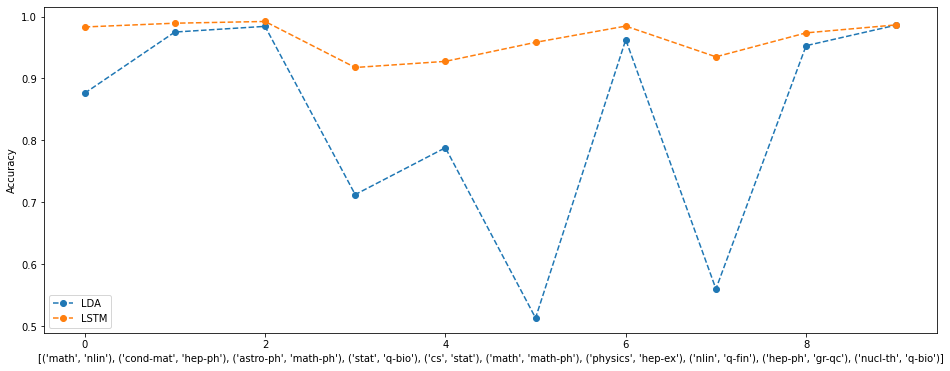

In [ ]:
lda_2017=[0.87615741,0.97494922,0.98413234,0.71248499,0.78810673,0.51316678,0.9625,0.56008902,0.95295446,0.98618573]
acc5 = [0.98314545,0.98923401,0.99204117,0.91771265,0.92758449,0.95833596,0.98456494,0.93495493,0.97361616,0.98652915]
fig = plt.figure(figsize=(16,6))
x = np.arange(10)
plt.plot(x,lda_2017,'o',linestyle='dashed',label='LDA')
plt.plot(x,acc5,'o',linestyle='dashed',label='LSTM')
plt.xlabel(list_2)
plt.ylabel('Accuracy')
plt.legend()

results_num=[30081.,18763.,14575.,5189.,29096.,30698.,11338.,1538.,7088.,2969.]


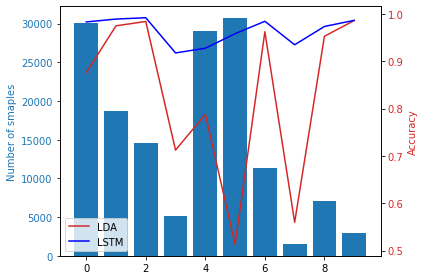

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('Number of smaples', color=color)
ax1.bar(x, results_num, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # 创建共用x轴的第二个y轴
color = 'tab:red'
ax2.set_xlabel(list_2)
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(x, lda_2017, color=color,label='LDA')
ax2.plot(x, acc5, color='b',label='LSTM')
ax2.legend()
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()